# Group: I-Need-More-Boolets



## Members:
Go, Ryan Jefferson <br>
Ejercito, Joshua Carl <br>
Moraña, Anton Louis <br>
Nieva, Samuel



Section: S11



# Introduction to the problem/task and dataset

This major course output tasked our group to select a real-word dataset from the selection given. This group has selected the stars dataset, which is a dataset containing spectral characteristics derived from pictures taken by the SDSS (Sloan Digital Sky Survey). This dataset's main use is spectral classification, i.e., classifying whether a celestial body is a star, a quasar or an entire galaxy.

Using the dataset, the group is to perform the following:

- Describe the dataset
- Perform Data Pre-processing and Cleaning
- Perform Exploratory Data Analysis
- Select 3 Machine Learning Models
- Perform model training
- Perform hyperparameter tuning
- Extract insights from the data



# Description of the dataset

As stated earlier, the Stars datasets contains spectral characteristics from celestial bodies that can be used to classify it as either a quasar, star, or galaxy. This dataset is made up of 100,000 obersavations of space taken by the SDSS (Sloan Digital Sky Survey) with each observations having 18 features. The SDSS takes these observations through the use of a 2.5m wide located at Apache Point Observatory in New Mexico. The telescope is described in detail in a paper by Gunn et al. (2006), and it is through this powerful telescope that a robust astronomical survey is created, from which datasets such as this are derived.

The following are the description of their features:

1. obj_ID =  the unique value that identifies the object in the image catalog used by th CAS (Chinese Academy of Sciences).
2. alpha = it contains the right ascension angle, it is measured from the start of a point which is called vernal equinox and go eastward. It is expressed in hours, minutes, and seconds. Vernal equinox is when the sun is exactly above the equator and day and night are of equal day. It is similar to the longitude in space.
3. delta = it contains the declination angle, which shows the angle between the celestial equator and a point on the celestial sphere. It is like the latitude in space which results can either be positive or negative. Positive means that the object is located north while negative means it is located south.
4. u – Ultraviolet filter in the photometric system.
5. g – Green filter in the photometric system.
6. r – Red filter in the photometric system.
7. i – Near Infrared filter in the photometric system.
8. z – Infrared filter in the photometric system.
9. run_ID – Run Number used to identify the specific scan.
10. rerun_ID – Rerun Number to specify how the image was processed.
11. cam_col – Camera column to identify the scanline within the run.
12. field_ID – Field number to identify each field.
13. spec_obj_ID – Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class).
14. class – object class (galaxy, star or quasar object). This is the label the group will be tasking the models to predict.
15. redshift – redshift value based on the increase in wavelength.
16. plate – plate ID, identifies each plate in SDSS (Sloan Digital Sky Survey).
17. MJD – Modified Julian Date, used to indicate when a given piece of SDSS (Sloan Digital Sky Survey) data was taken.
18. fiber_ID – identifies the fiber that pointed the light at the focal plane in each observation.

The first few rows of the dataset look like this:



In [1]:
import pandas as pd
import numpy as np

seed_num = 12


np.random.seed(seed_num)

stars = pd.read_csv('stars.csv')
print("stars dataset shape: ", stars.shape)
stars.head()

stars dataset shape:  (100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


The following shows the number of data points for each class.

In [2]:
stars['class'].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

The following shows the datatypes of each feature within the dataset:

In [3]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

# List of requirements

The group will be using Python's scikit learn library for their classification models (I think), scipy, scikit, numpy and pandas array for processing data, and matplotlib for visualizing data (add stuff if need pa)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
import matplotlib.pyplot as plt
import metrics as metrics

import numpy as np

# Data Cleaning and Preprocessing



To begin, we assign a set of columns that will be the focus for data cleaning and preprocessing, namely the `alpha`, `delta` `u`, `g`, `r`, `i`, `z`, and `redshift` columns.

In [5]:
columns_to_clean = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

## Replacement of `obj_ID` column



The `obj_ID` column assigns a unique ID for each observation in the dataset, although it is represented in a floating point format. For the purposes of the study, this will be replaced with a similarly-named column that utilizes integer IDs instead in order to simplify the access to each element.



In [6]:
stars = stars.drop(['obj_ID'], axis=1)
stars['obj_ID'] = np.arange(len(stars))
stars.insert(0, 'obj_ID', stars.pop('obj_ID'))
stars

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


## Checking for empty observations

Checking was done for any entries with missing/null features by instantiating another stars dataset whose entries are filtered off of null features.

In [7]:
nan_variables = stars[stars.isnull().any(axis=1)].index
stars_nonull = stars.drop(labels=nan_variables).reset_index(drop=True)
print("stars dataset shape (no null): ", stars_nonull.shape)

stars dataset shape (no null):  (100000, 18)


As shown by the resulting filtered dataset and comparing its shape to the original dataset, it was shown that all entries have all their features accounted for.

## Checking for duplicate entries

Any duplicated entries was checked first by comparing all entries' columns to each other

In [8]:
stars.duplicated().any()

False

As shown, there are no duplicated entries within the dataset.

## Checking for outliers

The removal of outliers aims to craft a dataset whose subset can be used for training data that is generally representative of each classes. We will first check for the existence of outliers in this instance, and any suspicious outliers that implies default/placeholder values will be removed from analysis.



In [9]:
stars[(np.abs(stats.zscore(stars[columns_to_clean])) < 3).all(axis=1)].shape

(97884, 18)

There are 2116 data points that are considered as outliers based from the z-score metric (>= 3 standard deviations from the mean). In order to know more about these outliers, the features are drawn in a boxplot, displaying their minimum and maximum values respectively.

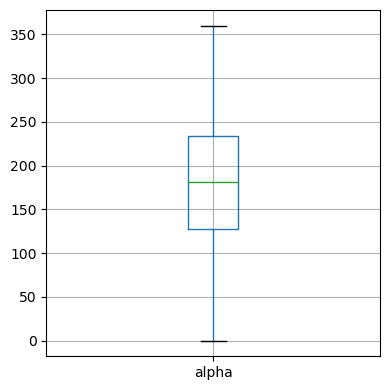

" alpha " minimum value:  0.0055278279239701
" alpha " maximum value:  359.999809770956


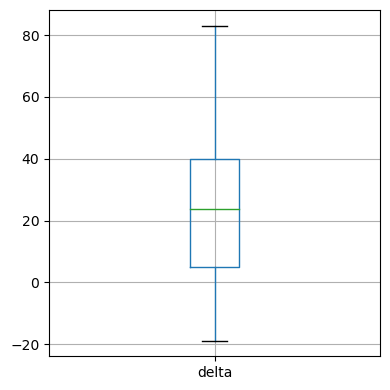

" delta " minimum value:  -18.7853280771825
" delta " maximum value:  83.00051858898


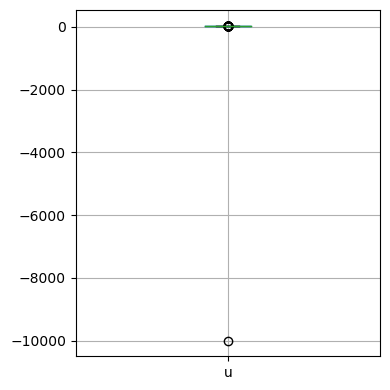

" u " minimum value:  -9999.0
" u " maximum value:  32.78139


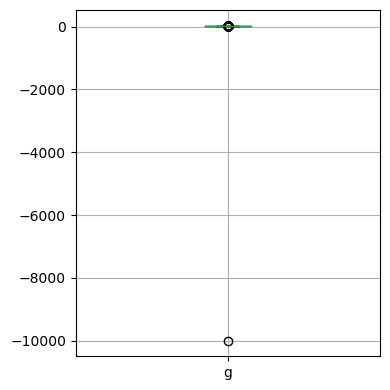

" g " minimum value:  -9999.0
" g " maximum value:  31.60224


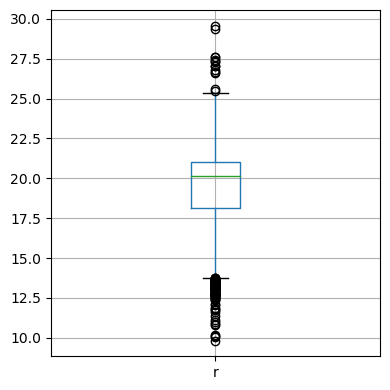

" r " minimum value:  9.82207
" r " maximum value:  29.57186


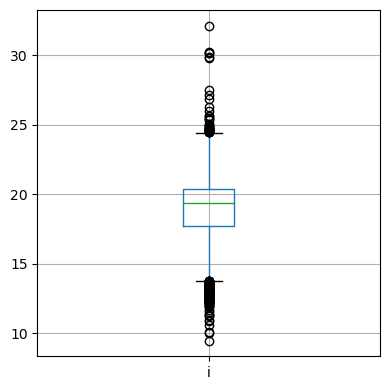

" i " minimum value:  9.469903
" i " maximum value:  32.14147


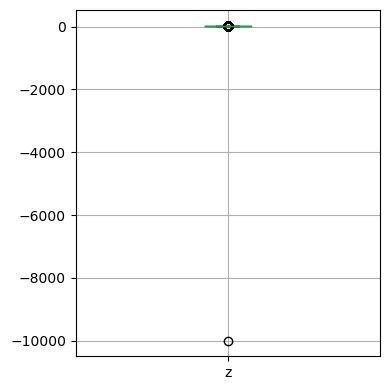

" z " minimum value:  -9999.0
" z " maximum value:  29.38374


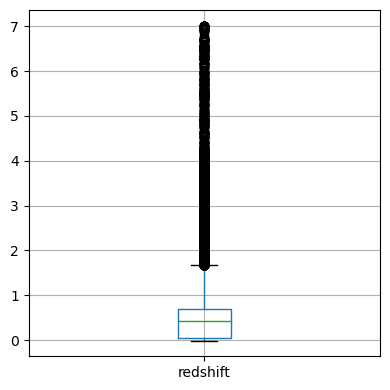

" redshift " minimum value:  -0.009970667
" redshift " maximum value:  7.011245


In [10]:
for col in columns_to_clean:
    stars.boxplot(col, figsize=(4, 4))
    plt.tight_layout()
    plt.show()
    print("\"",col,"\" minimum value: ", stars[col].min())
    print("\"",col,"\" maximum value: ", stars[col].max())

Some features have values equated to a whole value of \-9999. This may indicate that these features were not recorded/not available for that observation, thus putting a default value for those features. To resolve this, we will remove the associated entries that has default values for these certain features.

In [11]:
default_value = stars['u'].min()
stars = stars[stars['u'] != default_value]
stars = stars[stars['g'] != default_value]
stars = stars[stars['z'] != default_value]
stars.shape

(99999, 18)

Based from the filtered dataset, there is only one entry that contains such default values. Any other outliers' effects will be resolved by applying the robust scaling method for normalization.



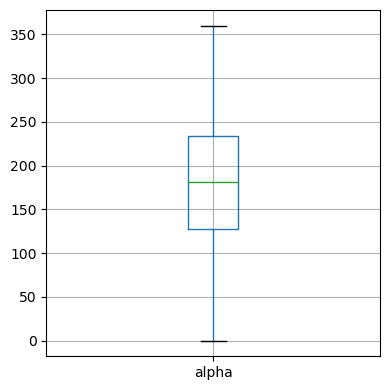

" alpha " minimum value:  0.0055278279239701
" alpha " maximum value:  359.999809770956


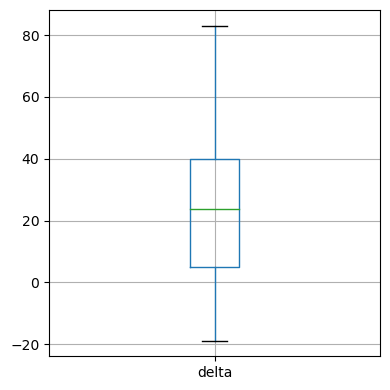

" delta " minimum value:  -18.7853280771825
" delta " maximum value:  83.00051858898


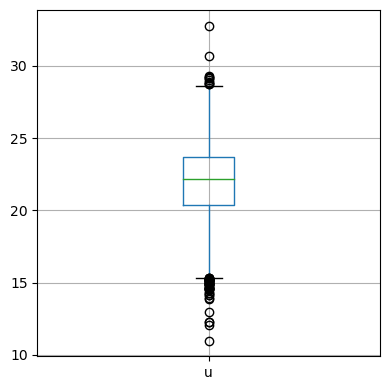

" u " minimum value:  10.99623
" u " maximum value:  32.78139


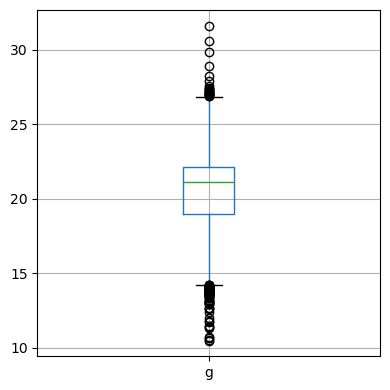

" g " minimum value:  10.4982
" g " maximum value:  31.60224


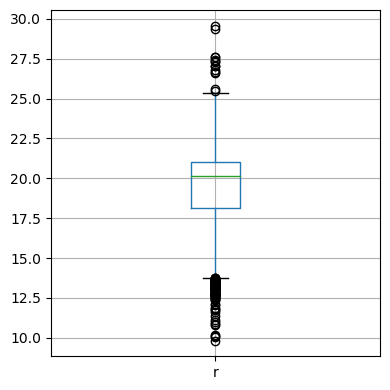

" r " minimum value:  9.82207
" r " maximum value:  29.57186


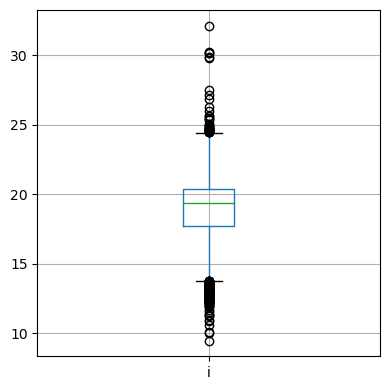

" i " minimum value:  9.469903
" i " maximum value:  32.14147


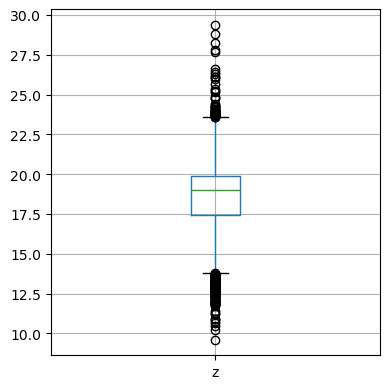

" z " minimum value:  9.612333
" z " maximum value:  29.38374


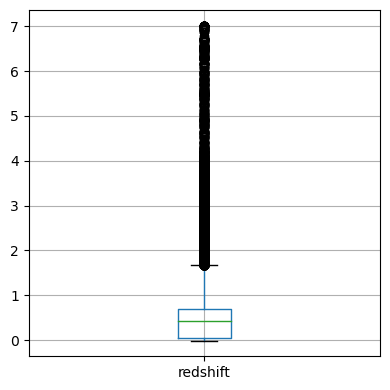

" redshift " minimum value:  -0.009970667
" redshift " maximum value:  7.011245


In [12]:
for col in columns_to_clean:
    stars.boxplot(col, figsize=(4, 4))
    plt.tight_layout()
    plt.show()
    print("\"",col,"\" minimum value: ", stars[col].min())
    print("\"",col,"\" maximum value: ", stars[col].max())

The boxplots indicates that any extreme outliers that comes from the default values were successfully removed. However, the `redshift` feature may require additional feature engineering in the form of logarithmic transformation, which will be done in the normalization phase.



## Logarithmic transformation of the `redshift` feature



The `redshift` feature will be transformed by implementing a helper function to be used in the normalization process.

In [13]:
def log_transform_feature(df, feature):
    feature_min = df[feature].min()
    feature_max = df[feature].max()
    # shifter to convert negaative values to positive, and to keep any values above zero for log computation
    shifter = abs(feature_min) + 0.001
        
    df[feature] = np.log(df[feature] + shifter)
    
    return df

## Fixing `obj_ID` after the removal of outliers

Since the outliers were removed, the row obj_ID may not reflect it's actual position in the dataset. To fix this, we simply reassign the obj_IDs incrementally.



In [14]:
stars = stars.drop(['obj_ID'], axis=1)
stars['obj_ID'] = np.arange(len(stars))
stars.insert(0, 'obj_ID', stars.pop('obj_ID'))
stars

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99994,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,99995,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,99996,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,99997,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


## Normalization



Before proceeding to the normalization process, we will only assign the feature columns that we have deemed as necessary, such as the photometric data that was recorded by the instrumentation, rather than the parameters of the instrumentations since we have deemed them to have negligible effects or may overfit the machine learning models with unneeded features that we will utilize.

Normalization is performed for the included feature columns in order to equally weight\-in each of the features for the model training and evaluation. The robust scaler will be applied as normalization technique to account for the massive outliers for some features such as `u`, `g,` and `z`.

In order to begin the normalization process, the original dataset is split into training and test dataset alongside splitting their features and labels, and are then normalized. This was done to simulate the prediction on unseen data by only doing the normalization computations within the split datasets themselves to avoid imposing any bias for the evaluation. Additionally, the redshift feature is log\-transformed first in order to balance\-out its skewed distribution.



In [15]:
# For use in EDA
og_stars = stars.copy()

cols = ['u','g','r','i','z','redshift']
X = stars[cols]
y = stars["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=seed_num, test_size=0.3, stratify=y)

# log-transform redshift features first
X_train = log_transform_feature(X_train, "redshift")
scaler = RobustScaler().fit(X_train[cols])
X_train[cols] = scaler.transform(X_train[cols])

X_test = log_transform_feature(X_test, "redshift")
scaler = RobustScaler().fit(X_test[cols])
X_test[cols] = scaler.transform(X_test[cols])

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

The original stars dataset is also normalized for comparison in the EDA process.

In [16]:
stars = log_transform_feature(stars, "redshift")
scaler = RobustScaler().fit(stars[columns_to_clean])
stars[columns_to_clean] = scaler.transform(stars[columns_to_clean])
stars.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,0,-0.425010,0.254593,0.509638,0.372125,0.092712,-0.089865,-0.085718,3606,301,2,79,6.543777e+18,GALAXY,0.165130,5812,56354,171
1,1,-0.339118,0.219477,0.779129,0.548340,0.845354,0.661718,1.060716,4518,301,5,119,1.176014e+19,GALAXY,0.249518,10445,58158,427
2,2,-0.363910,0.343441,0.924697,0.495154,0.166535,-0.021237,-0.022896,3606,301,2,120,5.152200e+18,GALAXY,0.171176,4576,55592,299
3,3,1.483780,-0.691984,-0.012689,0.847428,0.510936,0.412648,0.099785,4192,301,3,214,1.030107e+19,GALAXY,0.323658,9149,58039,775
4,4,1.545274,-0.070858,-0.822160,-1.114330,-1.247111,-1.286691,-1.406334,8102,301,3,137,6.891865e+18,GALAXY,-0.514844,6121,56187,842


# Exploratory Data Analysis



Proceeding with the exploratory data analysis process, we will first assign the photometric feature columns to a new dataset, in addition to two instrumentation features which are the "alpha" and "delta" to demonstrate the negligible effects of instrumentation data on the modelling process.


In [17]:
columns_to_use = ['obj_ID','alpha','delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'class']
columns_data = ['alpha','delta','u','g','r','i','z','redshift']

labels = {'GALAXY':0,'STAR':1,'QSO':2}

stars_df = stars[columns_to_use]
stars_df['class'] = stars_df['class'].map(labels)

stars_df.set_index('obj_ID')

C:\Users\tomat\AppData\Local\Temp\ipykernel_29500\3563447924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_df['class'] = stars_df['class'].map(labels)


,alpha,delta,u,g,r,i,z,redshift,class
obj_ID,,,,,,,,,
0,-0.425010,0.254593,0.509638,0.372125,0.092712,-0.089865,-0.085718,0.165130,0
1,-0.339118,0.219477,0.779129,0.548340,0.845354,0.661718,1.060716,0.249518,0
2,-0.363910,0.343441,0.924697,0.495154,0.166535,-0.021237,-0.022896,0.171176,0
3,1.483780,-0.691984,-0.012689,0.847428,0.510936,0.412648,0.099785,0.323658,0
4,1.545274,-0.070858,-0.822160,-1.114330,-1.247111,-1.286691,-1.406334,-0.514844,0
...,...,...,...,...,...,...,...,...,...
99994,-1.328101,-0.755034,-0.003463,0.593924,0.611459,0.713276,0.703612,-1.539587,0
99995,-1.423299,-0.110709,0.153532,0.407262,0.111626,0.132286,0.166915,-0.018958,0
99996,0.410679,-0.228628,-0.302836,-0.579370,-0.660376,-0.643642,-0.671624,-0.433603,0


## Central Tendencies

To gain a better understanding of the data, we can begin with examining the central tendencies that are applicable for the data, which are the mean and the median.


### Means

We can take the means of each feature, pertaining to each class and compare them to one another. Putting the means together in a table, it would look like this:



In [18]:
means_df = og_stars.groupby('class').mean()
means_df = means_df[['alpha','delta','u','g','r','i','z','redshift']].T

normalized_means_df = stars.groupby('class').mean()
normalized_means_df = normalized_means_df[['alpha','delta','u','g','r','i','z','redshift']].T

print("Raw data mean:\n", means_df)

print("\n")

print("Normalized data mean:\n", normalized_means_df)

Raw data mean:
 class         GALAXY         QSO        STAR
alpha     177.954727  180.474314  174.232180
delta      23.513911   26.808621   23.499671
u          22.587379   21.547619   21.153830
g          20.906101   20.926193   19.617142
r          19.587552   20.624089   18.947005
i          18.851990   20.431173   18.543760
z          18.449156   20.266732   18.334295
redshift    0.421596    1.719676   -0.000115


Normalized data mean:
 class       GALAXY       QSO      STAR
alpha    -0.027692 -0.004007 -0.062686
delta    -0.003814  0.090987 -0.004224
u         0.122408 -0.189358 -0.307433
g        -0.061367 -0.055006 -0.469454
r        -0.184860  0.171461 -0.405056
i        -0.207625  0.385110 -0.323317
z        -0.225763  0.513001 -0.272450
redshift -0.123088  0.513845 -1.544378


We can then graph it to a bar plot to make it easier to compare to one another. The bar chart for the raw data means is shown by the following:

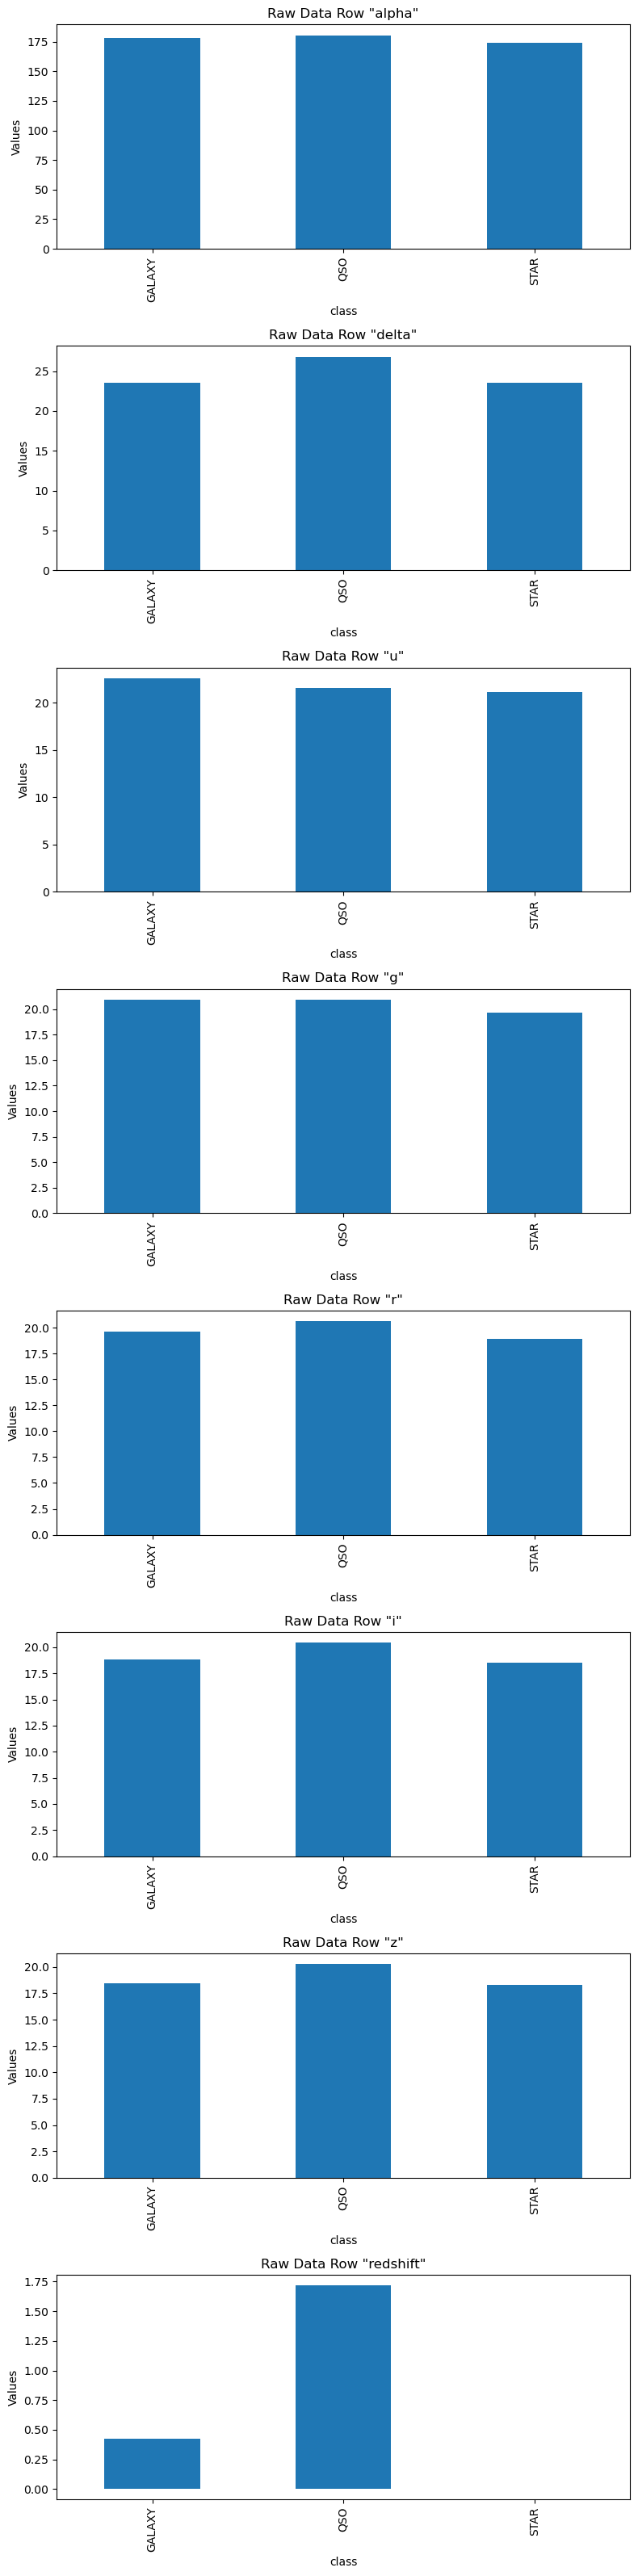

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(means_df), figsize=(8, 4 * len(means_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(means_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Raw Data Row \"{index}\"')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

As seen from the raw data graph, the magnitudes of the raw features' values are massive, which may hinder certain models from deriving the differences between the classes; models that are sensitive to unnormalized data such as regression-based models and k-nearest neighbors. As such, normalization was performed in order to rescale the features relative to each other.

The following shows the bar chart for the means of the normalized features:

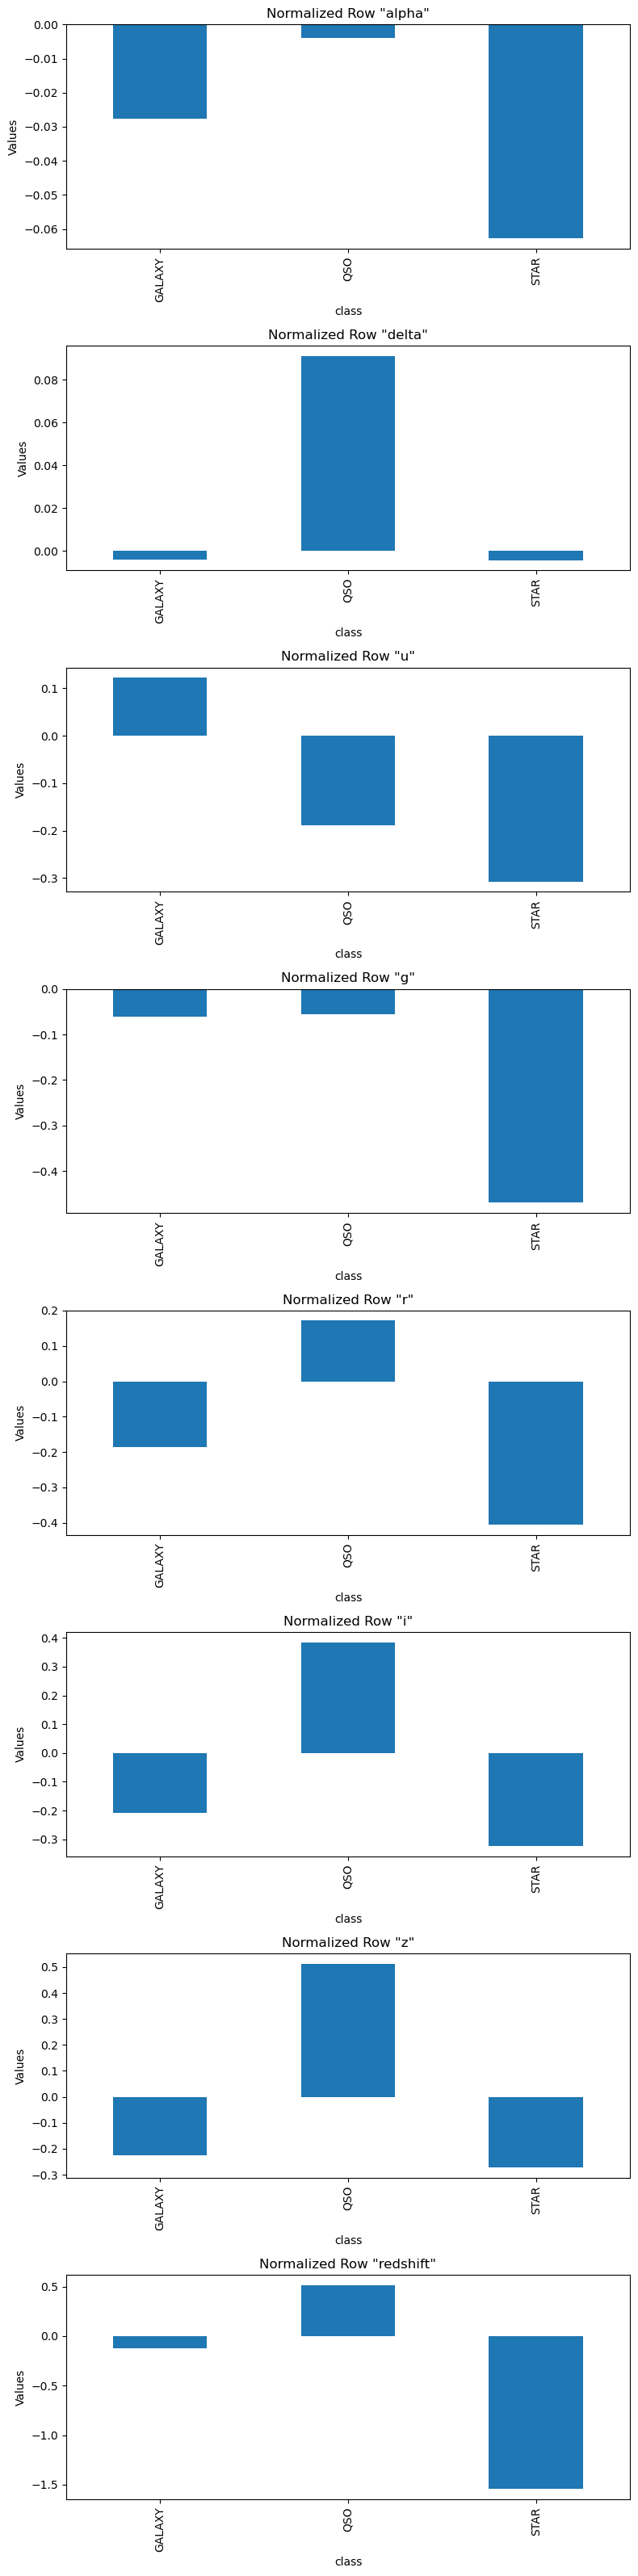

In [20]:
fig, axes = plt.subplots(nrows=len(normalized_means_df), figsize=(8, 4 * len(normalized_means_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(normalized_means_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Normalized Row \"{index}\"')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

By rescaling the features through the usage of robust scaling, the differences between the classes are now more apparent.

### Median
The median for the raw features are also compared to their normalized counterparts in order to further verify the effects of normalization.

The following shows the median values for the raw data:


In [21]:
median_df = og_stars.groupby('class').median()
median_df = median_df[['alpha','delta','u','g','r','i','z','redshift']].T

normalized_median_df = stars.groupby('class').median()
normalized_median_df = normalized_median_df[['alpha','delta','u','g','r','i','z','redshift']].T


print(median_df)
print("\n")
print(normalized_median_df)

class         GALAXY         QSO        STAR
alpha     181.315787  183.682504  174.149512
delta      22.301731   29.299167   23.400590
u          22.841770   21.503240   21.010650
g          21.582200   21.056290   19.542830
r          20.104590   20.772720   18.955130
i          19.223660   20.582110   18.592390
z          18.766630   20.373970   18.319230
redshift    0.456274    1.617232   -0.000076


class       GALAXY       QSO      STAR
alpha     0.003904  0.026152 -0.063463
delta    -0.038693  0.162649 -0.007075
u         0.198685 -0.202664 -0.350364
g         0.152688 -0.013817 -0.492982
r        -0.007123  0.222555 -0.402263
i        -0.068121  0.441764 -0.305064
z        -0.096724  0.556589 -0.278573
redshift  0.029772  0.551986 -1.542501


The bar chart for the median of the raw data is shown by the following:

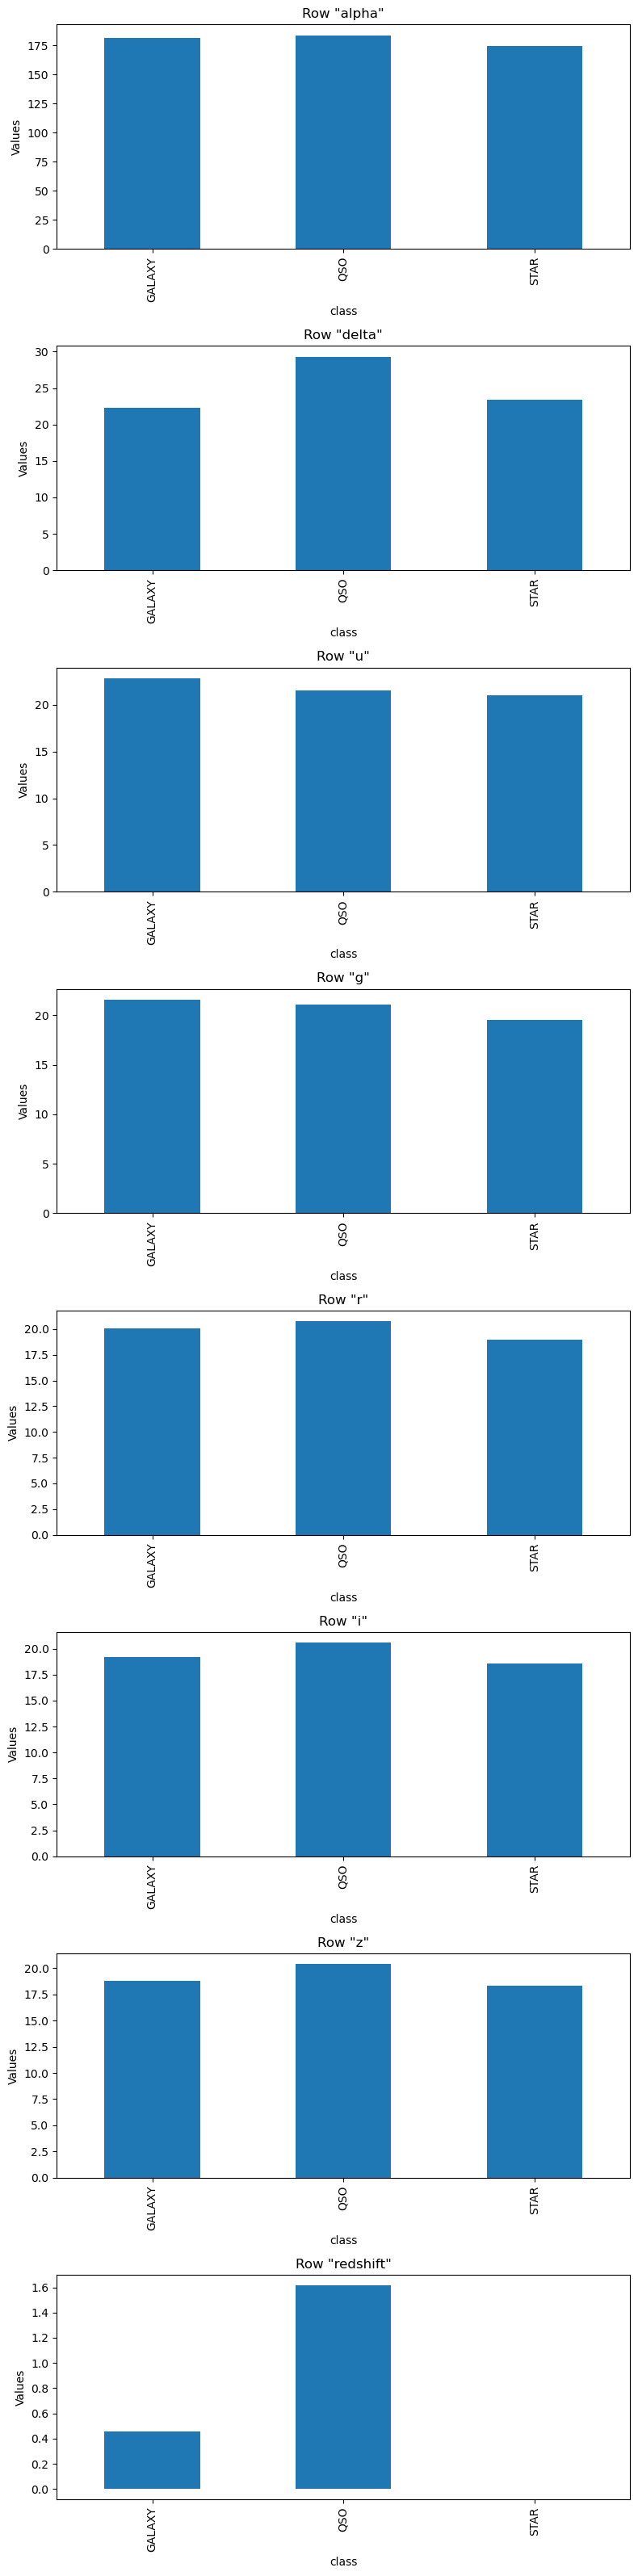

In [22]:
fig, axes = plt.subplots(nrows=len(median_df), figsize=(8, 4 * len(median_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(median_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Row \"{index}\"')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

As expected, based from the bar chart for the raw data means, the feature scales for the raw data median are also massive.

The following shows the bar chart for the median of the normalized features:

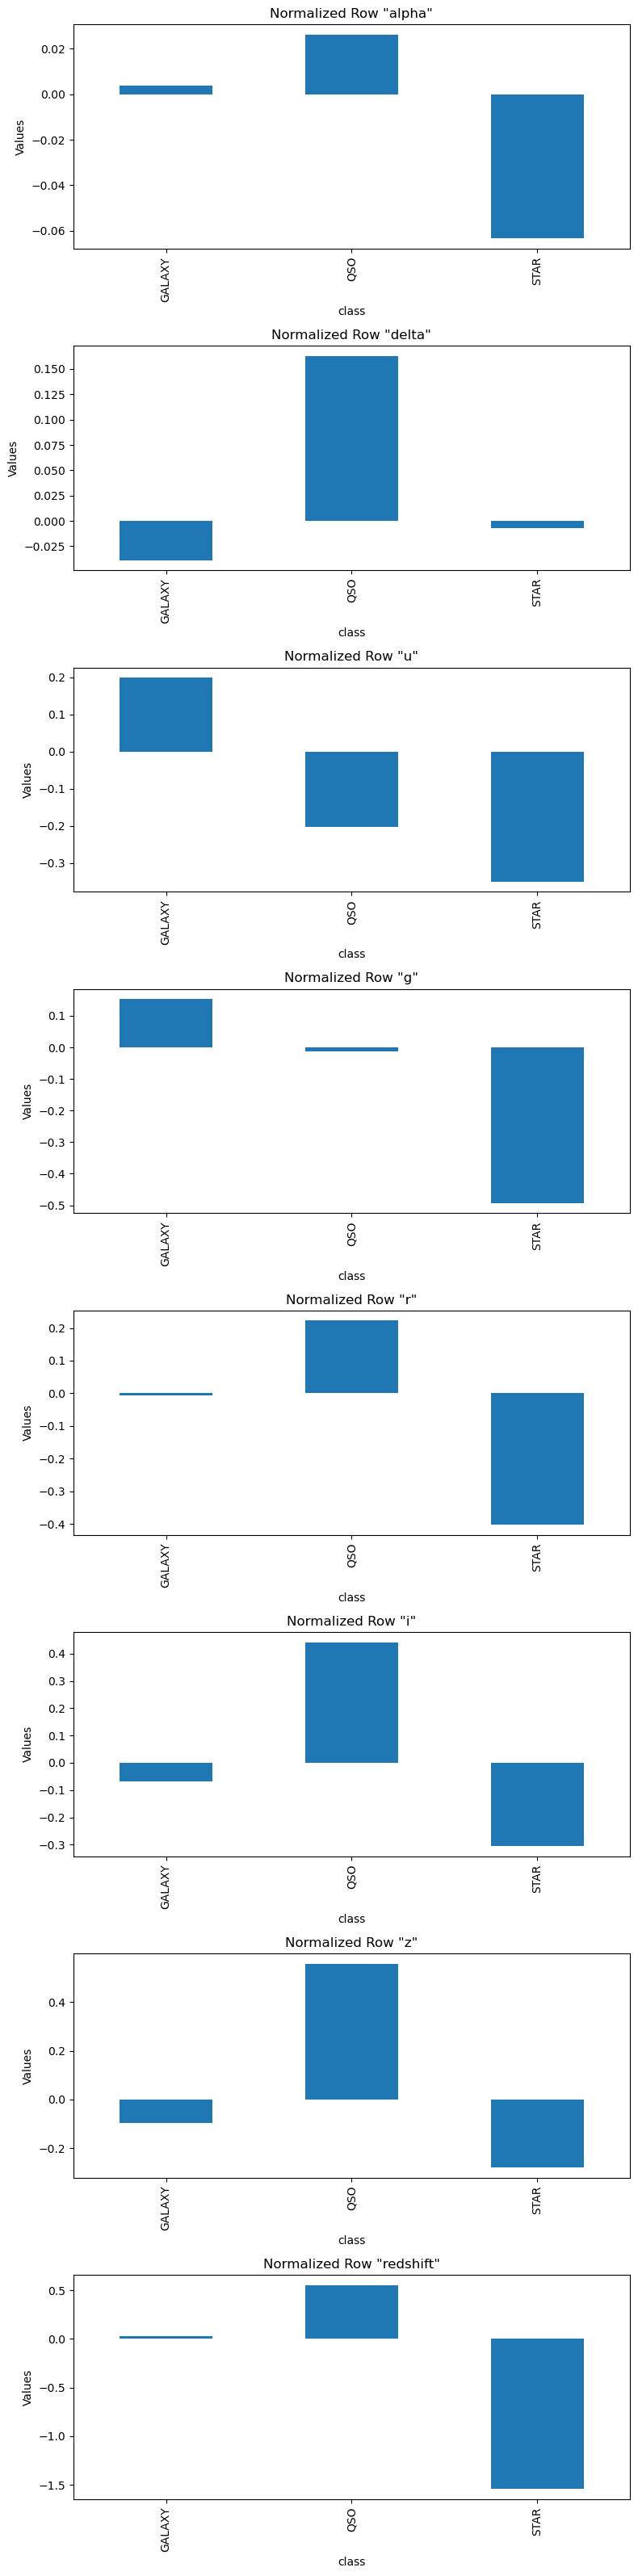

In [23]:
fig, axes = plt.subplots(nrows=len(normalized_median_df), figsize=(8, 4 * len(normalized_median_df)))

# Iterate through each row and plot a bar graph
for i, (index, row) in enumerate(normalized_median_df.iterrows()):
    # Create a bar plot for each row
    ax = axes[i]
    row.plot(kind='bar', ax=ax, title=f'Normalized Row \"{index}\"')
    ax.set_ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Similarly to the bar chart of the means of the normalized values, the differences between the features are more apparent through normalization.

The following shows the box plot for the normalized data, which can be helpful to further visualize the differences between the classes:

In [24]:
stars_df.boxplot(columns_data, by="class", figsize=(20,18))

array([[<Axes: title={'center': 'alpha'}, xlabel='class'>,
        <Axes: title={'center': 'delta'}, xlabel='class'>,
        <Axes: title={'center': 'u'}, xlabel='class'>],
       [<Axes: title={'center': 'g'}, xlabel='class'>,
        <Axes: title={'center': 'r'}, xlabel='class'>,
        <Axes: title={'center': 'i'}, xlabel='class'>],
       [<Axes: title={'center': 'z'}, xlabel='class'>,
        <Axes: title={'center': 'redshift'}, xlabel='class'>, <Axes: >]],
      dtype=object)

The boxplots for the normalized data above implies that the photometric features have certain distinctions between their classes when visually analyzed side-by-side, in contrast to the instrumentation data for alpha and delta. As such the instrumentation features will not be included for the model training part since they imply little distinction between the three classes and may not be useful for model training.

One thing to also note about the classes is the overlapping regions between the interquartile ranges of the different classes, which may imply that certain values that may exist for a certain class can also be categorized for another class. As such, the complete utilization of the feature set for the photometric data may be needed in order to derive an effective model from the given data. Although interestingly, the redshift feature might become pivotal for the classification tasks as can be seen from the differences between the classes of the labels.

Another thing to note of above is the relatively balanced distributions that the features for each classes have in terms of the positioning of the median values relative to their interquartile ranges and outliers, which may help with models that are sensitive against skewed data such as k-nearest neighbors.

### Outliers
The outlier samples of each feature will also be shown in order to determine their proportion relative to the size of the sample. All outliers will be defined as feature samples at and beyond 3 standard deviations from the mean.

In [25]:
outliers_df = pd.DataFrame()

for feature in cols:
    tmp = (stats.zscore(stars[feature]) >= 3)
    outliers_df[feature] = tmp
    print("\"", feature, "\" outliers: ", len(tmp[tmp==True]))

print("\n")
    
for feature in cols:
    print("\"", feature, "\"outlier percentage: ", 100 * sum(outliers_df[feature])/len(stars), " %")

" u " outliers:  8
" g " outliers:  25
" r " outliers:  19
" i " outliers:  73
" z " outliers:  26
" redshift " outliers:  0


" u "outlier percentage:  0.008000080000800007  %
" g "outlier percentage:  0.025000250002500026  %
" r "outlier percentage:  0.01900019000190002  %
" i "outlier percentage:  0.07300073000730008  %
" z "outlier percentage:  0.026000260002600025  %
" redshift "outlier percentage:  0.0  %


Based from the values above, the outliers may have negligible impact on the overall result of the models since their proportion within the dataset is low.

# Model Training

The following are the models that will be utilized for training, hyperparameter tuning and testing.

1. Multinomial Regression
2. Random Forest
3. K\-Nearest Neighbors



### Multinomial Regression

The first model featured is the Logistic/Multinomial Regression since it can be seen that there are linearly/polynomial-separable features within the normalized dataset which could help with the classification.

In order to begin, the Stochastic Gradient Descent Classifier was imported from the Scikit-learn library for usage, as well as defining the hyperparameters to be used for the hyperparameter tuning portion, which consist of the learning rate for the model, spanning ranges within a=0.001 up to a=0.100 in 0.001 steps.



In [26]:
from sklearn.linear_model import SGDClassifier

alpha = np.arange(0.001, 0.101, 0.001)
logis_hyperparameters = [
    {
        'eta0': alpha
    }

]

Before setting up the logistic regression model, we need to vectorize the labels, otherwise we will not be able to compute the RMSE later on since RMSE can only compute continuous values. Our labels contain strings which we need to vectorize first:


In [27]:
y_train_MLR = y_train.copy()

labels = {'GALAXY':0,'STAR':1,'QSO':2}

label_set = np.vectorize(lambda x: labels[x])
y_train_MLR = label_set(y_train_MLR)

y_train_MLR

array([0, 2, 1, ..., 1, 0, 2])

In [28]:
y_test_MLR = y_test.copy()

labels = {'GALAXY':0,'STAR':1,'QSO':2}

label_set = np.vectorize(lambda x: labels[x])
y_test_MLR = label_set(y_test_MLR)

y_test_MLR

array([2, 2, 1, ..., 0, 0, 0])

The SGDClassifier features several parameters, one of which is the regularization methods, of which we will use the default L2 regularization parameter. We will utilize a learning rate of 0.001 for the meantime, as well as a constant learning rate.

For now, we will verify the regularization method for the model by predicting both the training data and the test data, and comparing whether they are sufficiently similar to each other through their prediction accuracy.

In [29]:
logistic_model = SGDClassifier(loss='log_loss', eta0=0.001, learning_rate='constant', random_state=seed_num, verbose=0)

##### Model training:

In [30]:
logistic_model.fit(X_train, y_train_MLR)

SGDClassifier(eta0=0.001, learning_rate='constant', loss='log_loss',
              random_state=12)

##### Model prediction for the training data:



In [31]:
logistic_predictions = logistic_model.predict(X_train)
logistic_predictions

array([0, 2, 1, ..., 1, 2, 2])

In [32]:
print(f"Train Accuracy: {metrics.compute_accuracy(logistic_predictions, y_train_MLR):.4f}%")

Train Accuracy: 94.8840%


In [33]:
rmse = metrics.compute_rmse(logistic_predictions, y_train_MLR)
print(f"Training Root Mean Squared Error: {rmse:.4f}")

Training Root Mean Squared Error: 0.4089


##### Model prediction for the test data:



In [34]:
logistic_predictions = logistic_model.predict(X_test)
logistic_predictions

array([2, 0, 1, ..., 0, 0, 0])

In [35]:
print(f"Test Accuracy: {metrics.compute_accuracy(logistic_predictions, y_test_MLR):.4f}%")

Test Accuracy: 94.5930%


In [36]:
logis_rmse = metrics.compute_rmse(logistic_predictions, y_test_MLR)
print(f"Test Root Mean Squared Error: {logis_rmse:.4f}")

Test Root Mean Squared Error: 0.4227


Based from the results above, the training and test accuracy for the logistic model is very similar to each other, which implies a model that is sufficiently low-bias and low-variance.

In [37]:
### ------END OF LOGISTIC REGRESSION------

### Random Forest

From the EDA, we saw distinct differences between the features of the three classes. From that, we theorized that, since the features are distinct, there would be little overlapping instances which makes the data a good fit for Random Forest.

Since sklearn's Random Forest implementation can only work with numerical values, we must convert our labels from strings to integer labels. To do this, we can simply run a lambda function across all the values to convert them.

The mapping goes as follows: Galaxy: 0 | Star: 1 | QSO: 2



In [38]:
y_train_RF = y_train.copy()

labels = {'GALAXY':0,'STAR':1,'QSO':2}

label_set = np.vectorize(lambda x: labels[x])
y_train_RF = label_set(y_train_RF)

y_train_RF

array([0, 2, 1, ..., 1, 0, 2])

We have to do the same for the test set as well:

In [39]:
y_test_RF = y_test.copy()

labels = {'GALAXY':0,'STAR':1,'QSO':2}

label_set = np.vectorize(lambda x: labels[x])
y_test_RF = label_set(y_test_RF)

y_test_RF

array([2, 2, 1, ..., 0, 0, 0])

Now, we can proceed with the training and fitting of our initial model.

In [40]:
rfc = RandomForestClassifier(random_state=seed_num)
rfc.fit(X_train, y_train_RF)

RandomForestClassifier(random_state=12)

Now, we can attempt a prediction with our model to test its performance prior to any Hyperparameter tuning. First, let's check the accuracy and RMSE in the train set.

In [41]:
predictions_train_RF = rfc.predict(X_train)


accuracy_train_RF = metrics.compute_accuracy(predictions_train_RF, y_train_RF)
rmse_train_RF = metrics.compute_rmse(predictions_train_RF, y_train_RF)

print("Train Accuracy: ", accuracy_train_RF)
print("Train RMSE: ", rmse_train_RF)

Train Accuracy:  99.997
Train RMSE:  0.008451602916093027


Then, the test set:

In [42]:
predictions_test_RF = rfc.predict(X_test)

accuracy_test_RF = metrics.compute_accuracy(predictions_test_RF, y_test_RF)
rmse_test_RF = metrics.compute_rmse(predictions_test_RF, y_test_RF)

print("Test Accuracy: ", accuracy_test_RF)
print("Test RMSE: ", rmse_test_RF)

Test Accuracy:  97.13
Test RMSE:  0.3043024810940588


Right now, the model shows no signs of under or overfitting due to the fact that it returned high accuracy and low RMSE for both the train and the test set. It also shows that our initial assumption based on our EDA is correct in that there are very little overlapping instances in the dataset which makes it a good set for Random Forest. Now, let us see if we can further increase the model's performance with hyperparameter tuning in the next section.


### K-Nearest Neighbors

KNN is a model that searches for the nearest neighbors and bases on the prediction on them. KNN is utilized here because it properly fits the goal which is classification. While KNN does not need to train since it only needs to find the nearest neighbors and get the majority class specifically on this task that identifies whether the celestial body is a star, galaxy or quasar. Instead of training the model, what happens is that the data will be become neighbors that will aid in predicting new instances 

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

train_results = knn.predict(X_train)
test_results = knn.predict(X_test)

print("Train Score:",metrics.compute_accuracy(train_results, y_train))
print("Test Score:",metrics.compute_accuracy(test_results, y_test))

Train Score: 97.684
Test Score: 96.9


The KNN model does not show any signs of overfitting due to having a high accuracy for predicting on both train and test dataset and their difference is not significantly high.

# Hyperparameter tuning



### Multinomial Logistic Regression



For the multinomial logistic regression, we will utilize GridSearchCV for its hyperparameter tuning. For this logistic regression model, we are only looking for the best "eta0" or the alpha learning rate. Hence, GridSearchCV can work because it can exhaust the best possible hyperparameters for the model without major performance issues since we are only tuning the alpha learning rate of the model.

The hyperparameter dictionary for the GridSearchCV is shown below:

- 'eta0': float, default=1
  - Constant which the updates are multiplied \(alpha learning rate\)



Now let's make a new logistic regression model using the defaults with a random\_state of 1.


In [44]:
logistic_model = SGDClassifier(loss='log_loss', learning_rate='constant', random_state=seed_num, verbose=0)

We now call GridSearchCV to pass the logistic regression model, the hyperparameter dictionary, with n\_jobs of 12 and 10 cross validation folds. Afterwards, we set it into the new logistic regression model that will be used to train with the later best hyperparameters. 


In [45]:
best_logis_model = GridSearchCV(logistic_model, logis_hyperparameters, n_jobs=12, cv=10)

In [46]:
best_logis_model.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=SGDClassifier(learning_rate='constant', loss='log_loss',
                                     random_state=12),
             n_jobs=12,
             param_grid=[{'eta0': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])}])

After training the new model, we get the best possible parameter and in our case, we are looking for the best possible "eta0" or the alpha learning rate of the model.



In [47]:
best_alpha = best_logis_model.best_params_["eta0"]
best_logis_model.best_params_

{'eta0': 0.098}

Let's check the cross\-validation results of the new model to see how the GridSearchCV got the best parameter.


In [48]:
cv_results = best_logis_model.cv_results_

We can also check the accuracy of each of the parameters as well.



In [49]:
for params, loss in zip(cv_results['params'], cv_results['mean_test_score']):
    print(f"Parameters: {params}, Accuracy: {loss}")

Parameters: {'eta0': 0.001}, Accuracy: 0.9476278713285572
Parameters: {'eta0': 0.002}, Accuracy: 0.9508993611332232
Parameters: {'eta0': 0.003}, Accuracy: 0.952070783581328
Parameters: {'eta0': 0.004}, Accuracy: 0.9524993407221439
Parameters: {'eta0': 0.005}, Accuracy: 0.9531850692956138
Parameters: {'eta0': 0.006}, Accuracy: 0.9540850692956138
Parameters: {'eta0': 0.007}, Accuracy: 0.9547279264384709
Parameters: {'eta0': 0.008}, Accuracy: 0.9547565448125243
Parameters: {'eta0': 0.009000000000000001}, Accuracy: 0.9545279795072764
Parameters: {'eta0': 0.010000000000000002}, Accuracy: 0.9546279795072765
Parameters: {'eta0': 0.011}, Accuracy: 0.9547565529769558
Parameters: {'eta0': 0.012}, Accuracy: 0.9547851244055273
Parameters: {'eta0': 0.013000000000000001}, Accuracy: 0.954899414202029
Parameters: {'eta0': 0.014000000000000002}, Accuracy: 0.9550422774682099
Parameters: {'eta0': 0.015}, Accuracy: 0.9550994223664604
Parameters: {'eta0': 0.016}, Accuracy: 0.9549851386932826
Parameters: {'

Now, let's recreate the model with the new best alpha learning rate value and train it again to check the predictions.


In [50]:
best_logistic_model = SGDClassifier(loss='log_loss', eta0=best_alpha, max_iter=200, learning_rate='constant', random_state=seed_num, verbose=0)

In [51]:
best_logistic_model.fit(X_train, y_train)

SGDClassifier(eta0=0.098, learning_rate='constant', loss='log_loss',
              max_iter=200, random_state=12)

In [52]:
logistic_predictions = best_logistic_model.predict(X_test)
logistic_predictions

array(['QSO', 'GALAXY', 'STAR', ..., 'GALAXY', 'GALAXY', 'GALAXY'],
      dtype='<U6')

Let's check the maximized accuracy of the new model with the best hyperparameter.

In [53]:
print(f"{metrics.compute_accuracy(logistic_predictions, y_test)}%")

95.7%


The accuracy is 

### Random Forest

For the purposes of our Random Forest's hyperparameter tuning, we'll be using RandomizedSearchCV. This method, from the name, itself, randomly passes a set of hyper parameters given to it and returns the best set of hyper parameters found. This was primarily considered in contrast to the previously-used GridSearchCV due to the massive computational costs of trying every permutation of each feature for the given hyperparameter values, as well as the long training time of random forest models relative to other models such as the previously-tested multinomial/logistic regression model.

Before we can initialize we must construct a dictionary of the hyperparameters we want to optimize.

The hyperparameters of Random Forest include:

- **n_estimators**: int, default=100
  - The number of trees in the forest. 
<br><br>

- **criterion**: {“gini”, “entropy”, “log_loss”}, default=”gini”
  - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain, see Mathematical formulation. 
  - Note: This parameter is tree-specific.
  <br><br>

- **max_depth**: int, default=None
  - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain fewer than min_samples_split samples.
<br><br>

- **min_samples_split**: int or float, default=2
  - The minimum number of samples required to split an internal node:
    - If int, then consider min_samples_split as the minimum number.
    - If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
<br><br>

- **min_samples_leaf**: int or float, default=1
  - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
    - If int, then consider min_samples_leaf as the minimum number.
    - If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) is the minimum number of samples for each node.



When it comes to looking for values for these hyperparameters, we looked to a paper by Zhu, et. al. for a valid baseline wherein they optimized their Random Forest model's hyperparameters for power industrial control systems intrusion detection. Though what they're predicting is different, the range of values they used may may allow us to find our model's optimal hyperparemeters.

They're range of values are as follows:

- n_estimators: Multiples of 10 up to 300

- criterion: gini or entropy

- max_depth: Multiples of 2 to 48

- min_samples_split: 2 incremented until 10

- min_samples_leaf: 1 incremented until 10

Due to hardware limitations, we kept the range the same, but chose higher increments to minimize the time it takes to optimize the hyper parameters.

With this in mind, let's set up the dictionary for our hyperparameters:

In [54]:
hyperparameters_RF = {
    'n_estimators': [i for i in range(100,301,100)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(16, 49, 16)],
    'min_samples_split': [i for i in range(5, 11, 5)],
    'min_samples_leaf': [i for i in range (5, 11, 5)]
}

print(hyperparameters_RF)

{'n_estimators': [100, 200, 300], 'criterion': ['gini', 'entropy'], 'max_depth': [16, 32, 48], 'min_samples_split': [5, 10], 'min_samples_leaf': [5, 10]}


Now, let's initialize our Randomized Search CV:

In [55]:
rsc = RandomizedSearchCV(rfc, hyperparameters_RF, n_iter=10, cv=3, random_state=seed_num, verbose=3, n_jobs=12)

Now, let's use it to find the best hyper parameters of our model.

In [56]:
rsc.fit(X_train, y_train_RF)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12),
                   n_jobs=12,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [16, 32, 48],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=12, verbose=3)

After the RandomizedSearchCV runs this course, we're left with these results:

In [57]:
rsc_results = pd.DataFrame(rsc.cv_results_)
rsc_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,80.493978,2.863873,0.483932,0.023037,100,10,5,16,entropy,"{'n_estimators': 100, 'min_samples_split': 10,...",0.979343,0.975614,0.978957,0.977971,0.001674,3
1,122.406920,6.125966,1.605507,0.673780,200,5,10,16,gini,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.978657,0.974800,0.978185,0.977214,0.001718,9
2,184.246461,20.034880,2.492190,0.215426,300,10,10,32,gini,"{'n_estimators': 300, 'min_samples_split': 10,...",0.978485,0.975057,0.978143,0.977228,0.001542,8
3,63.505482,12.373727,0.890804,0.297336,100,10,5,32,entropy,"{'n_estimators': 100, 'min_samples_split': 10,...",0.979557,0.975485,0.979257,0.978100,0.001853,2
4,145.360502,25.803949,1.336485,0.448242,200,5,5,16,entropy,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.979814,0.975571,0.979085,0.978157,0.001852,1
5,185.582373,7.654314,1.481266,0.305403,300,5,5,32,gini,"{'n_estimators': 300, 'min_samples_split': 5, ...",0.979214,0.975657,0.979043,0.977971,0.001638,3
6,150.099143,5.841059,1.138023,0.016585,300,5,10,16,gini,"{'n_estimators': 300, 'min_samples_split': 5, ...",0.978485,0.974842,0.978314,0.977214,0.001678,9
7,54.922605,8.381377,0.505230,0.083549,100,5,10,16,entropy,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.978443,0.974800,0.978785,0.977343,0.001804,7
8,58.761011,6.524199,0.369972,0.019703,100,10,10,48,entropy,"{'n_estimators': 100, 'min_samples_split': 10,...",0.978957,0.974714,0.978614,0.977428,0.001924,6
9,81.087777,4.307194,0.741373,0.079842,300,5,10,48,entropy,"{'n_estimators': 300, 'min_samples_split': 5, ...",0.978871,0.974842,0.978743,0.977485,0.001870,5


For a better look, these are the mean test scores in decending order, which shows that index 4 has the best hyper parameters and, by extension, performance:

In [58]:
rsc_results['mean_test_score'].sort_values(ascending=False)

4    0.978157
3    0.978100
0    0.977971
5    0.977971
9    0.977485
8    0.977428
7    0.977343
2    0.977228
1    0.977214
6    0.977214
Name: mean_test_score, dtype: float64

Through this, we find that the best hyper parameters for the model are:

In [59]:
print(rsc.best_params_)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 16, 'criterion': 'entropy'}


So, using this, we can then perform the tests once more:

In [60]:
predictions_train_RF = rsc.best_estimator_.predict(X_train)


accuracy_train_RF = metrics.compute_accuracy(predictions_train_RF, y_train_RF)
rmse_train_RF = metrics.compute_rmse(predictions_train_RF, y_train_RF)

print("Train Accuracy: ", accuracy_train_RF)
print("Train RMSE: ", rmse_train_RF)

Train Accuracy:  98.529
Train RMSE:  0.23679575503644495


In [61]:
predictions_test_RF = rsc.best_estimator_.predict(X_test)

accuracy_test_RF = metrics.compute_accuracy(predictions_test_RF, y_test_RF)
rmse_test_RF = metrics.compute_rmse(predictions_test_RF, y_test_RF)

print("Test Accuracy: ", accuracy_test_RF)
print("Test RMSE: ", rmse_test_RF)

Test Accuracy:  97.263
Test RMSE:  0.30276503540974914


In [62]:
Though the training accuracy and scores lessened, the test accuracy increased by ~0.1, showing marginal improvements over the original, unoptimized model.

SyntaxError: invalid syntax (4203267786.py, line 1)

### K-Nearest Neighbors



For hyperparameter tuning in KNN, we will be utilizing grid search to test different sets of hyperparameters and obtain the best set of hyperparameters and display their score for train and test. Grid search can be utilized in this instance since there is only one hyperparameter for the model.

The following are the hyperparameters that will be needing for tuning, the naming convention of hyperparameters are based on their documentation of sklearn.neighbors.KNeighborsClassifier
- **n_neighbors**: int, default=5
  - Number of neighbors to use by default.
<br><br>

They're range of values are as follows will allow us to find our model's optimal hyperparameters.
1. n_neighbors: from 5 then adding 20 until 245

Code below will contain the dictionary of our hyperparameters 

In [ ]:
hyperparameters_KNN = {
    'n_neighbors': np.arange(5,246,20),
}
hyperparameters_KNN

It is time to find the best hyperparameter for our KNN model

In [ ]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,hyperparameters_KNN,cv=5)
knn_cv.fit(X_train,y_train)

print("Hyperparameters:",knn_cv.best_params_)
print("Train Score:",knn_cv.best_score_)

Now we create a model with the best hyperparameter and display the accuracy when using X_train and X_test dataset

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

knn_train_results = knn.predict(X_train)
knn_test_results = knn.predict(X_test)

print("Train Score:",metrics.compute_accuracy(knn_train_results, y_train))
print("Test Score:",metrics.compute_accuracy(knn_test_results, y_test))

The difference of accuracy when using the best hyperparameter for KNN model when predicting train and test data is not significantly high thus the model is neither overfitting nor underfitting

# Model selection

### Multinomial Regression

### Random Forest Model:

In [ ]:
rsc.best_estimator_

In [ ]:
predictions_train_RF = rsc.best_estimator_.predict(X_train)


accuracy_train_RF = metrics.compute_accuracy(predictions_train_RF, y_train_RF)
rmse_train_RF = metrics.compute_rmse(predictions_train_RF, y_train_RF)

print("Train Accuracy: ", accuracy_train_RF)
print("Train RMSE: ", rmse_train_RF)
      
predictions_test_RF = rsc.best_estimator_.predict(X_test)

accuracy_test_RF = metrics.compute_accuracy(predictions_test_RF, y_test_RF)
rmse_test_RF = metrics.compute_rmse(predictions_test_RF, y_test_RF)

print("Test Accuracy: ", accuracy_test_RF)
print("Test RMSE: ", rmse_test_RF)

### K-Nearest Neighbors

# Insight and conclusion


The Random Forest model performed really well due to the fact that the data set contained no overlapping instances due to the nature of photometric data and how it is classified. Because of this, it was able to grasp the trends in how photometric data relates to Stars, Galaxies and Quasars and was able to differentiate and classify the instances of the three classes. However, the training and hyper parameter optimization of the model is very resource intensive, and as students, we lacked a good enough PC to do more robust optimization on it.

So, a recommendation is, if one has the required hardware, is to perform more robust hyper parameter testing with either: Wider ranges of hyper parameters to test, or more iterations in the RandomizedSearchCV to find better results. Or,use GridSearchCV, to search through all the possible configurations, instead.


# References
- Zhu, N., Zhu, C., Zhou, L., Zhu, Y., &amp; Zhang, X. (2022, October 17). Optimization of the random forest hyperparameters for power industrial control systems intrusion detection using an improved grid search algorithm. MDPI. https://doi.org/10.3390/app122010456 